In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, backend
import matplotlib.pyplot as plt
from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!unzip -q /content/drive/MyDrive/planets.zip

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create a data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1) # set validation split

# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/downloaded_images/',
                                       class_mode='categorical',
                                       target_size=(200, 200),
                                       subset='training') # set as training data

# load and iterate validation dataset
val_it = datagen.flow_from_directory('/content/downloaded_images/',
                                     class_mode='categorical',
                                     target_size=(200, 200),
                                     subset='validation') # set as validation data

Found 2464 images belonging to 11 classes.
Found 270 images belonging to 11 classes.


In [ ]:
# Get the class labels in the order they were loaded
class_labels = train_it.class_indices

# Sort the class labels by their index values to ensure consistency
sorted_class_labels = sorted(class_labels.items(), key=lambda pair:pair[1])

# Extract the planet names from the sorted class labels
planet_names = [label for label, _ in sorted_class_labels]

print("Planet names:", planet_names)

Planet names: ['Earth', 'Jupiter', 'MakeMake', 'Mars', 'Mercury', 'Moon', 'Neptune', 'Pluto', 'Saturn', 'Uranus', 'Venus']


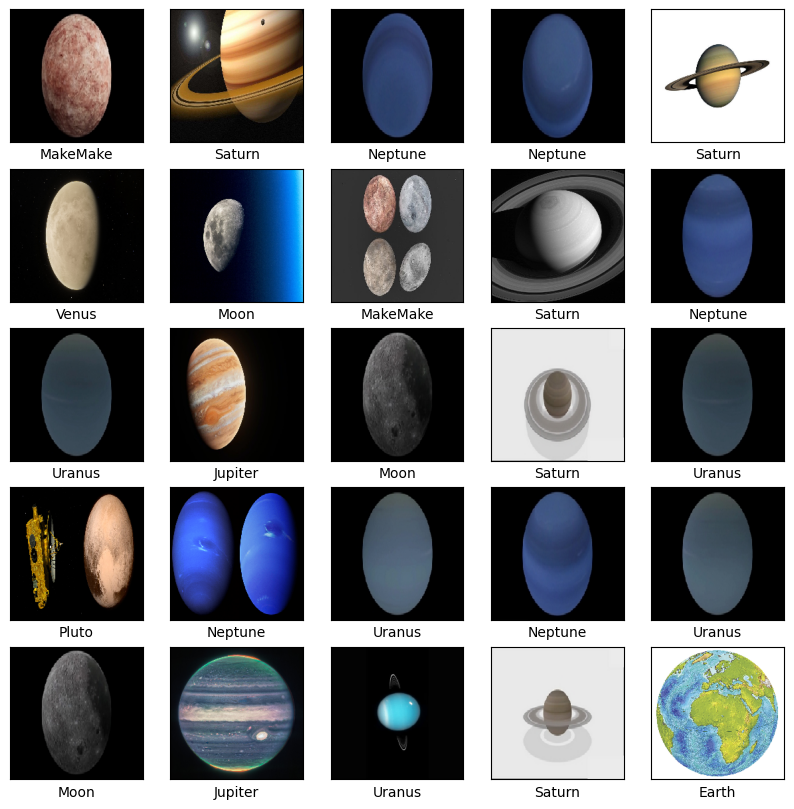

In [ ]:
#Validate the dataset

# get class labels
class_names = train_it.class_indices
class_names = list(class_names.keys())

# generate a batch of images and labels
batch_images, batch_labels = next(train_it)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch_images[i])
    # The labels are one-hot encoded, so convert them to integers
    plt.xlabel(class_names[np.argmax(batch_labels[i])])
plt.show()

In [ ]:
def model_builder(hp):
    input_shape = (200,200,3)
    model = keras.Sequential()

    model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same',input_shape=input_shape))
    model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    # Tune the dropout rate
    # Choose an optimal value between 0.1 and 0.5
    hp_dropout1 = hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout1))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
    # Tune the dropout rate
    # Choose an optimal value between 0.1 and 0.5
    hp_dropout2 = hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(hp_dropout2))

    model.add(layers.Flatten())

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))


    model.add(keras.layers.Dense(11))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train_it,
             epochs=50,
             validation_data=val_it,
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
print(f"""
The hyperparameter search is complete.\n
dropout units 1: {best_hps.get('dropout1')},\n
dropout units 2: {best_hps.get('dropout2')},\n
Dense layer units 1: {best_hps.get('units1')},\n
Dense layer units 2: {best_hps.get('units2')},\n
Learning rate: {best_hps.get('learning_rate')}
""")

Trial 30 Complete [00h 04m 37s]
val_accuracy: 0.12222222238779068

Best val_accuracy So Far: 0.9037036895751953
Total elapsed time: 00h 57m 50s

The hyperparameter search is complete.

dropout units 1: 0.2,

dropout units 2: 0.4,

Dense layer units 1: 416,

Dense layer units 2: 288,

Learning rate: 0.001



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_it,
                    epochs=50,
                    validation_data=val_it)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
77/77 [==============================] - 27s 329ms/step - loss: 1.8967 - accuracy: 0.3308 - val_loss: 1.2633 - val_accuracy: 0.4222
Epoch 2/50
77/77 [==============================] - 21s 279ms/step - loss: 1.1237 - accuracy: 0.6002 - val_loss: 0.5840 - val_accuracy: 0.7815
Epoch 3/50
77/77 [==============================] - 23s 297ms/step - loss: 0.7239 - accuracy: 0.7455 - val_loss: 0.4690 - val_accuracy: 0.8370
Epoch 4/50
77/77 [==============================] - 22s 286ms/step - loss: 0.5395 - accuracy: 0.8011 - val_loss: 0.4897 - val_accuracy: 0.8778
Epoch 5/50
77/77 [==============================] - 20s 262ms/step - loss: 0.3289 - accuracy: 0.8892 - val_loss: 0.4796 - val_accuracy: 0.8074
Epoch 6/50
77/77 [==============================] - 21s 280ms/step - loss: 0.2194 - accuracy: 0.9278 - val_loss: 0.5897 - val_accuracy: 0.8704
Epoch 7/50
77/77 [==============================] - 20s 266ms/step - loss: 0.1352 - accuracy: 0.9574 - val_loss: 0.7679 - val_accuracy: 0.8259

In [ ]:
# Build the model with the optimal hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model with the best epoch
history=hypermodel.fit(train_it,
               epochs=best_epoch,
               validation_data=val_it)


Epoch 1/44
77/77 [==============================] - 24s 277ms/step - loss: 1.8079 - accuracy: 0.3815 - val_loss: 1.0437 - val_accuracy: 0.6704
Epoch 2/44
77/77 [==============================] - 21s 267ms/step - loss: 1.1091 - accuracy: 0.6234 - val_loss: 0.8196 - val_accuracy: 0.6926
Epoch 3/44
77/77 [==============================] - 22s 280ms/step - loss: 0.7676 - accuracy: 0.7135 - val_loss: 0.5371 - val_accuracy: 0.8370
Epoch 4/44
77/77 [==============================] - 20s 263ms/step - loss: 0.5557 - accuracy: 0.8028 - val_loss: 0.5340 - val_accuracy: 0.7815
Epoch 5/44
77/77 [==============================] - 21s 276ms/step - loss: 0.3733 - accuracy: 0.8665 - val_loss: 0.5382 - val_accuracy: 0.8259
Epoch 6/44
77/77 [==============================] - 21s 266ms/step - loss: 0.3143 - accuracy: 0.8908 - val_loss: 0.4093 - val_accuracy: 0.8556
Epoch 7/44
77/77 [==============================] - 21s 267ms/step - loss: 0.1938 - accuracy: 0.9403 - val_loss: 0.4406 - val_accuracy: 0.8741

9/9 [==============================] - 1s 54ms/step - loss: 0.8727 - accuracy: 0.8852
[test loss, test accuracy]: [0.8726512789726257, 0.885185182094574]


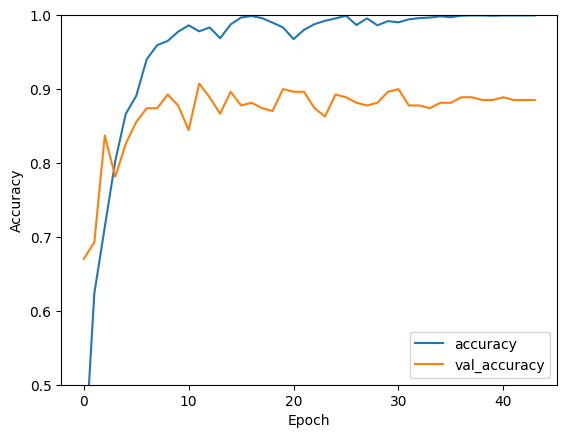

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

eval_result = hypermodel.evaluate(val_it)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
hypermodel.save('my_model.keras')  # creates a keras file 'my_model.keras'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(hypermodel)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)